In [59]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from QLearningUCB import QLearningUCB as ucb
import pandas as pd
import seaborn as sns
from pathlib import Path

In [60]:
home = str(Path.home())

f_csma_list = [
    home + "/UFMG/SOMAC-ML/data/_BKP/29092018/csma/round2/backlog_file.npy", # RUN
    home + "/UFMG/SOMAC-ML/data/10102018/round1/csma/backlog_file.npy",      # RUN3
    home + "/UFMG/SOMAC-ML/data/06102018/run4/5/csma/backlog_file.npy"       # RUN4
]

f_tdma_list = [
    home + "/UFMG/SOMAC-ML/data/_BKP/29092018/tdma/round2/backlog_file.npy", # RUN
    home + "/UFMG/SOMAC-ML/data/10102018/round1/tdma/backlog_file.npy",      # RUN3
    home + "/UFMG/SOMAC-ML/data/06102018/run4/5/tdma/backlog_file.npy"       # RUN4
]

In [61]:
def calc_reward(curr, prev):
    # Positive reward
    if curr > 1.1 * prev and curr <= 1.2 * prev:
        reward = 1.
        
    elif curr > 1.2 * prev and curr <= 1.4 * prev:
        reward = 2.
        
    elif curr > 1.4 * prev and curr <= 1.6 * prev:
        reward = 3.
        
    elif curr > 1.6 * prev and curr <= 1.8 * prev:
        reward = 4.
        
    elif curr > 1.8 * prev and curr <= 2.0 * prev:
        reward = 5.
        
    elif curr > 2.0 * prev:
        reward = 6.

    # Negative reward
    elif prev > 1.1 * curr and prev <= 1.2 * curr:
        reward = -1.

    elif prev > 1.2 * curr and prev <= 1.4 * curr:
        reward = -2.
        
    elif prev > 1.4 * curr and prev <= 1.6 * curr:
        reward = -3.
        
    elif prev > 1.6 * curr and prev <= 1.8 * curr:
        reward = -4.
        
    elif prev > 1.8 * curr and prev <= 2.0 * curr:
        reward = -5.
        
    elif prev > 2.0 * curr:
        reward = -6.

    else:
        reward = 0.

    return reward

def test(init_prot = 0, learn_rate = 0.3, discount = 0.8, dic = {}):
    logging.basicConfig(filename="/tmp/out.log", level = logging.INFO)
    
    dic["learn_rate"].append(learn_rate)
    dic["discount"].append(discount)
    
    prot   = init_prot
    somac  = ucb(prot, learn_rate = learn_rate, discount = discount, c = 1.)
    metric = {}
    t      = 0
    dt     = -1

    decision = prot
    backlog  = {}
    
    while t < n:
        metric[t] = t_csma[t] if prot == 0 else t_tdma[t]
        #print("Metrics = {}".format(metric[t]))
        #print("t = {}, dt = {}".format(t, dt))

        backlog[t] = prot

        if dt > 1:
            if dt == 2:
                reward = calc_reward(metric[t], metric[t-2])
            elif dt == 3:
                reward = calc_reward(metric[t], metric[t-3])
            else:
                reward = calc_reward(metric[t], metric[t-1]) * 0.01
                #reward = reward if reward == 0 else reward ** -dt

            somac.update_qtable(reward, dt)

            if dt == 2 and reward > 0:
                decision = somac.decision(prot, keep = True)
            elif dt == 2 and reward < 0.:
                decision = somac.decision(prot, force_switch = True)
            else:
                decision = somac.decision(prot, keep = False)

            if decision != prot:
                dt = 0
        else:
            _ = 0
            #print("MAC prot was switched recently. No switch now")


        t = t + 1
        dt = dt + 1

        #print("Protocol: {}".format(
        #    "CSMA" if prot == 0 else "TDMA"
        #))

        prot = decision

        #print("Decision: {}".format(
        #    "CSMA" if prot == 0 else "TDMA"
        #))

        #print("\n=============================\n")
        
    return backlog, metric
        
        
def calc_stats(backlog, metric, dic = {}):
    n_csma  = 0
    n_tdma  = 0
    n_somac = 0
    n_changes = 0
    
    per_threshold = 0.9
    dic["threshold"].append(per_threshold)
    
    for t in range(n):
        if t_csma[t] >= per_threshold * t_tdma[t]:
            n_csma = n_csma + 1

            if backlog[t] == 0:
                n_somac = n_somac + 1

        if t_tdma[t] >= per_threshold * t_csma[t]:
            n_tdma = n_tdma + 1

            if backlog[t] == 1:
                n_somac = n_somac + 1

    for t in range(1, n, 1):
        if backlog[t-1] != backlog[t]:
            n_changes = n_changes + 1
    
    #########################################################################

    norm = np.max([
        round(np.mean(t_csma), 2),
        round(np.mean(t_tdma), 2),
        round(np.mean([metric[t] for t in range(n)]), 2)
    ])
    
    dic["csma_count"].append(round(n_csma * 1. / n, 2))
    dic["tdma_count"].append(round(n_tdma * 1. / n, 2))
    dic["hit_rate"].append(round(n_somac * 1. / n, 2))
    dic["n_switches"].append(n_changes)
    dic["n_tot"].append(n)
    dic["csma_performance"].append(round(np.mean(t_csma), 2))
    dic["tdma_performance"].append(round(np.mean(t_tdma), 2))
    dic["somac_performance"].append(round(np.mean([metric[t] for t in range(n)]), 2))
    dic["csma_per_performance"].append(round(np.mean(t_csma) / norm, 2))
    dic["tdma_per_performance"].append(round(np.mean(t_tdma) / norm, 2))
    dic["somac_per_performance"].append(round(np.mean([metric[t] for t in range(n)]) / norm, 2))

In [62]:
fname_list = [
    "./_tmp/ucb/run.npy",
    "./_tmp/ucb/run3.npy",
    "./_tmp/ucb/run4.npy"
]

for fname, f_csma, f_tdma in (zip(fname_list, f_csma_list, f_tdma_list)):
    
    d_csma = np.load(f_csma, encoding = "latin1").item()
    d_tdma = np.load(f_tdma, encoding = "latin1").item()

    n = np.min([len(d_csma), len(d_tdma)]) - 10

    t_csma = np.array([d_csma[t]["metrics"][0, 1] for t in range(n)])
    t_tdma = np.array([d_tdma[t]["metrics"][0, 1] for t in range(n)])

    results = {
        "learn_rate":            [],
        "discount":              [],
        "threshold":             [],
        "csma_count":            [],
        "tdma_count":            [],
        "hit_rate":              [],
        "n_switches":            [],
        "n_tot":                 [],
        "csma_performance":      [],
        "tdma_performance":      [],
        "somac_performance":     [],
        "csma_per_performance":  [],
        "tdma_per_performance":  [],
        "somac_per_performance": []
    }

    for step in range(10):

        prot = 0 if step % 2 == 0 else 1
        
        if step % 5 == 0:
            print("file: {},\tstep: {}".format(fname, step))

        learn_rate_list = [i/10. for i in range(11)]
        discount_list = [i/10. for i in range(11)]

        for learn_rate in learn_rate_list:
            for discount in discount_list:
                backlog, metric = test(init_prot = prot, learn_rate = learn_rate, discount = discount, dic = results)
                calc_stats(backlog, metric, dic = results)

    np.save(fname, results)

file: ./_tmp/ucb/run.npy,	step: 0
file: ./_tmp/ucb/run.npy,	step: 5
file: ./_tmp/ucb/run3.npy,	step: 0
file: ./_tmp/ucb/run3.npy,	step: 5
file: ./_tmp/ucb/run4.npy,	step: 0
file: ./_tmp/ucb/run4.npy,	step: 5


In [63]:
df = pd.DataFrame.from_dict(results)

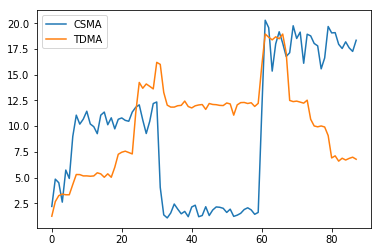

In [64]:
plt.plot(t_csma); plt.plot(t_tdma); plt.legend(["CSMA", "TDMA"])

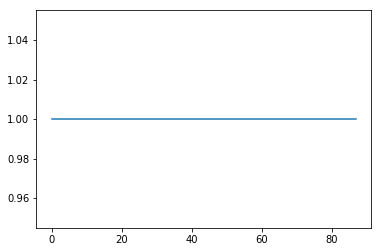

In [65]:
x = list(backlog.keys())
y = [backlog[t] for t in x]
plt.plot(x, y)

In [66]:
print(learn_rate, discount)

1.0 1.0
